In [1]:
import os
import tqdm
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt

from utils import check_accuracy_classification
import transformers
from torch.optim import Adam
from models import BertProbeClassifer
from utils import text_to_dataloader, tokenize_word
from bert_embedding import BertEmbeddingExtractorRandom

In [2]:
#%load_ext autoreload
#%autoreload 2

# Data Exploration

In [3]:
train_path = os.path.join("data","en_partut-ud-train.conllu")
dev_path = os.path.join("data","en_partut-ud-dev.conllu")
test_path = os.path.join("data","en_partut-ud-test.conllu")

In [4]:
HEADER_CONST = "# sent_id = "
TEXT_CONST = "# text = "
STOP_CONST = "\n"
WORD_OFFSET = 1
LABEL_OFFSET = 3
NUM_OFFSET = 0


def txt_to_dataframe(data_path):
    '''
    read UD text file and convert to df format
    '''
    with open(data_path, "r") as fp:
        df = pd.DataFrame(
            columns={
                "text",
                "word",
                "label"
            }
        )
        for line in fp.readlines():
            if TEXT_CONST in line:
                words_list = []
                labels_list = []
                num_list = []
                text = line.split(TEXT_CONST)[1]
                # this is a new text, need to parse all the words in it
            elif line is not STOP_CONST and HEADER_CONST not in line:
                temp_list = line.split("\t")
                num_list.append(temp_list[NUM_OFFSET])
                words_list.append(temp_list[WORD_OFFSET])
                labels_list.append(temp_list[LABEL_OFFSET])
            if line == STOP_CONST:
                # this is the end of the text, adding to df
                cur_df = pd.DataFrame(
                    {
                        "text": len(words_list) * [text],
                        "word": words_list,
                        "word_offset": num_list,
                        "label": labels_list
                    }
                )
                df = pd.concat([df,cur_df])
        return df
            


In [5]:
df_train = txt_to_dataframe(train_path)
df_dev = txt_to_dataframe(dev_path)
df_test = txt_to_dataframe(test_path)

In [6]:
TYPES = [
    "ADJ",
    "ADP",
    "ADV",
    "AUX",
    "CCONJ",
    "DET",
    "INTJ",
    "NOUN",
    "NUM",
    "PART",
    "PRON",
    "PROPN",
    "PUNCT",
    "SCONJ",
    "SYM",
    "VERB",
    "X",
    "_"
]

In [7]:
df_train[df_train["label"] == "INTJ"]

,word,text,label,word_offset
0,Yes,"Yes, Mrs Schroedter, I shall be pleased to loo...",INTJ,1
62,etc.,"For this reason, one of the most important and...",INTJ,63
4,right,"We know that, right?\n",INTJ,5
17,yes,In developing countries that have not yet reac...,INTJ,18
0,Yes,"Yes, being better connected with each other, t...",INTJ,1
48,etc.,in an answer to the sharers' petition in 1635 ...,INTJ,49


In [8]:
file_name = 'tex_artifacts/label_dist_train.tex'
SORT_COL = "Count"

with open(file_name,'w') as tf:
    display_df = df_train["label"].value_counts().rename_axis("Type").to_frame("Count").reset_index()
    #display_df.index = TYPES
    display_df.sort_values(by=SORT_COL, inplace=True, ascending=False)
    latex_data = display_df.to_latex(index=False)
    tf.write(latex_data)
    print(display_df.to_markdown(index=False))

| Type   |   Count |
|:-------|--------:|
| NOUN   |    9249 |
| ADP    |    5220 |
| PUNCT  |    5105 |
| DET    |    4616 |
| VERB   |    4126 |
| ADJ    |    3410 |
| AUX    |    2076 |
| PROPN  |    2033 |
| PRON   |    1734 |
| ADV    |    1707 |
| CCONJ  |    1472 |
| PART   |    1168 |
| NUM    |     787 |
| SCONJ  |     627 |
| X      |     140 |
| SYM    |      42 |
| _      |      27 |
| INTJ   |       6 |


In [9]:
file_name = 'tex_artifacts/label_dist_dev.tex'


with open(file_name,'w') as tf:
    display_df = df_dev["label"].value_counts().rename_axis("Type").to_frame("Count").reset_index()
    #display_df.index = TYPES
    display_df.sort_values(by=SORT_COL, inplace=True, ascending=False)
    latex_data = display_df.to_latex(index=False)
    tf.write(latex_data)
    print(display_df.to_markdown(index=False))

| Type   |   Count |
|:-------|--------:|
| NOUN   |     568 |
| PUNCT  |     353 |
| ADP    |     297 |
| VERB   |     276 |
| DET    |     266 |
| ADJ    |     210 |
| PRON   |     153 |
| AUX    |     124 |
| ADV    |     108 |
| PROPN  |     107 |
| CCONJ  |      88 |
| NUM    |      60 |
| PART   |      56 |
| SCONJ  |      41 |
| X      |      13 |
| SYM    |       2 |
| _      |       1 |


In [10]:
file_name = 'tex_artifacts/label_dist_test.tex'


with open(file_name,'w') as tf:
    display_df = df_test["label"].value_counts().rename_axis("Type").to_frame("Count").reset_index()
    #display_df.index = TYPES
    display_df.sort_values(by=SORT_COL, inplace=True, ascending=False)
    latex_data = display_df.to_latex(index=False)
    tf.write(latex_data)
    print(display_df.to_markdown(index=False))

| Type   |   Count |
|:-------|--------:|
| NOUN   |     753 |
| ADP    |     488 |
| DET    |     439 |
| PUNCT  |     339 |
| VERB   |     326 |
| AUX    |     234 |
| ADJ    |     224 |
| ADV    |     131 |
| PRON   |     106 |
| CCONJ  |      96 |
| PROPN  |      90 |
| PART   |      66 |
| NUM    |      61 |
| SCONJ  |      51 |
| _      |       4 |
| X      |       2 |
| INTJ   |       2 |


In [11]:
print("Total Sentences:")
print(f"Train: {len(df_train.drop_duplicates(subset='text', keep='first'))}")
print(f"Dev:   {len(df_dev.drop_duplicates(subset='text', keep='first'))}")
print(f"Test:  {len(df_test.drop_duplicates(subset='text', keep='first'))}")

Total Sentences:
Train: 1780
Dev:   156
Test:  153


In [12]:
print("Total Words:")
print(f"Train: {len(df_train)}")
print(f"Dev:   {len(df_dev)}")
print(f"Test:  {len(df_test)}")

Total Words:
Train: 43545
Dev:   2723
Test:  3412


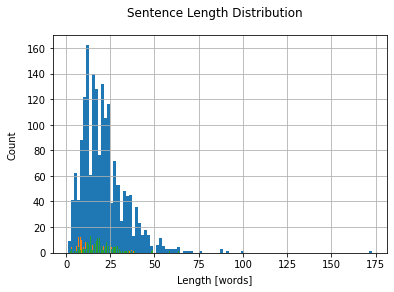

|       |   word_count |
|:------|-------------:|
| count |    1780      |
| mean  |      21.2225 |
| std   |      12.6585 |
| min   |       1      |
| 25%   |      13      |
| 50%   |      19      |
| 75%   |      27      |
| 95%   |      43      |
| max   |     173      |
|       |   word_count |
|:------|-------------:|
| count |    156       |
| mean  |     14.8526  |
| std   |      8.60068 |
| min   |      2       |
| 25%   |      8       |
| 50%   |     13       |
| 75%   |     20       |
| 95%   |     31.25    |
| max   |     39       |
|       |   word_count |
|:------|-------------:|
| count |     153      |
| mean  |      19.8824 |
| std   |       9.7427 |
| min   |       2      |
| 25%   |      14      |
| 50%   |      18      |
| 75%   |      25      |
| 95%   |      35      |
| max   |      64      |


In [13]:
df_train["word_count"] = df_train["text"].apply(lambda x: len(x.split(" ")))
df_dev["word_count"] = df_dev["text"].apply(lambda x: len(x.split(" ")))
df_test["word_count"] = df_test["text"].apply(lambda x: len(x.split(" ")))

fig, axes = plt.subplots()

train_sent_leb_dist = df_train.drop_duplicates(subset="text", keep="first")["word_count"].hist(bins=100)
dev_sent_leb_dist = df_dev.drop_duplicates(subset="text", keep="first")["word_count"].hist(bins=100)
test_sent_leb_dist = df_test.drop_duplicates(subset="text", keep="first")["word_count"].hist(bins=100)


plt.suptitle('Sentence Length Distribution', x=0.5, ha='center')
fig.text(0.5, 0.02, 'Length [words]', ha='center')
fig.text(0.02, 0.5, 'Count', va='center', rotation='vertical')

plt.show()


print(df_train.drop_duplicates(subset="text", keep="first")["word_count"].describe(percentiles=[.25,.50,.75,.95]).to_markdown())
print(df_dev.drop_duplicates(subset="text", keep="first")["word_count"].describe(percentiles=[.25,.50,.75,.95]).to_markdown())
print(df_test.drop_duplicates(subset="text", keep="first")["word_count"].describe(percentiles=[.25,.50,.75,.95]).to_markdown())

In [14]:
bert_tokenizer = transformers.BertTokenizer.from_pretrained("bert-base-uncased")

In [15]:
df_train, dataloader_train = text_to_dataloader(df_train, "cuda", 32, bert_tokenizer, 256)
#df_test, dataloader_test = text_to_dataloader(df_test, "cuda", 32, bert_tokenizer, 256)
#df_dev, dataloader_dev = text_to_dataloader(df_dev, "cuda", 32, bert_tokenizer, 256)

In [16]:
file_name = 'tex_artifacts/tokens_per_word_dist_train.tex'

INDEX_AXIS_NAME = "Tokens/Word"
SORT_COL = "Tokens/Word"

with open(file_name,'w') as tf:
    display_df = df_train["query_mask"].apply(lambda x: sum(x)).value_counts().rename_axis(INDEX_AXIS_NAME).to_frame("Count").reset_index()
    display_df.sort_values(by=SORT_COL, inplace=True)
    latex_data = display_df.to_latex(index=False)
    print(display_df.to_markdown(index=False))
    tf.write(latex_data)


|   Tokens/Word |   Count |
|--------------:|--------:|
|             0 |      55 |
|             1 |   41015 |
|             2 |    1388 |
|             3 |     729 |
|             4 |     161 |
|             5 |      24 |
|             6 |       6 |


In [17]:
df_train.sample(5)

,word,text,label,word_offset,word_count,label_idx,text_ids,attn_mask,query_mask
10,Cuthbert,in an answer to the sharers' petition in 1635 ...,PROPN,11,39,11,"[101, 1999, 2019, 3437, 2000, 1996, 3745, 2869...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."
16,updates,Allowing subscribers is a simple way to broade...,NOUN,17,21,7,"[101, 4352, 17073, 2003, 1037, 3722, 2126, 200...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
29,this,"We know, and we have stated as much in very ma...",PRON,30,57,10,"[101, 2057, 2113, 1010, 1998, 2057, 2031, 3090...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
10,produce,"Thus, a decline in the number of farmers could...",VERB,11,18,15,"[101, 2947, 1010, 1037, 6689, 1999, 1996, 2193...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."
0,He,He seems to have planned two contrasting serie...,PRON,1,8,10,"[101, 2002, 3849, 2000, 2031, 3740, 2048, 2213...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [18]:
file_name = 'tex_artifacts/tokens_per_word_dist_dev.tex'

INDEX_AXIS_NAME = "Tokens/Word"
SORT_COL = "Tokens/Word"

with open(file_name,'w') as tf:
    display_df = df_dev["query_mask"].apply(lambda x: sum(x)).value_counts().rename_axis(INDEX_AXIS_NAME).to_frame("Count").reset_index()
    display_df.sort_values(by=SORT_COL, inplace=True)
    latex_data = display_df.to_latex(index=False)
    print(display_df.to_markdown(index=False))
    tf.write(latex_data)


KeyError: 'query_mask'

In [ ]:
file_name = 'tex_artifacts/tokens_per_word_dist_test.tex'

INDEX_AXIS_NAME = "Tokens/Word"
SORT_COL = "Tokens/Word"

with open(file_name,'w') as tf:
    display_df = df_test["query_mask"].apply(lambda x: sum(x)).value_counts().rename_axis(INDEX_AXIS_NAME).to_frame("Count").reset_index()
    display_df.sort_values(by=SORT_COL, inplace=True)
    latex_data = display_df.to_latex(index=False)
    print(display_df.to_markdown(index=False))
    tf.write(latex_data)


In [ ]:
del bex

In [ ]:
import warnings
warnings.filterwarnings(action="ignore")


# extract bert base embedding
#for i in [1,2,3,4,5,6,7,8,9,10,11,12]:
for i in [12]:  
    #bex = BertEmbeddingExtractor(i, "bert-base-uncased")
    bex = BertEmbeddingExtractorRandom(i, "bert-base-uncased")
    embedding_df = bex.extract_embedding(dataloader_train, "sum")
    embedding_df.columns = [str(col) for col in embedding_df.columns]
#     save_path = os.path.join("bert_embeddings", f"bert_base_embedding_layer_{i}")
#     embedding_df.to_csv(save_path, index=False)

In [ ]:
embedding_df

In [ ]:

for df in [df_train, df_dev, df_test]:
    df["tokens_per_word"] = df["query_mask"].apply(lambda x: sum(x))
    df["tokens_per_sentence"] = df["attn_mask"].apply(lambda x: sum(x))
    #result = pd.pivot_table(df, index=["label"], columns="tokens_per_word" ,fill_value=0).astype(int)
    #print(result)
    #print(result.to_markdown())
    print(df["tokens_per_sentence"].describe(percentiles=[.25,.5,.75,.9,.95]).to_markdown())
    print()

# Neuron Correlation

In [ ]:
chosen_bert_layer = 12
bert_results_path = os.path.join("bert_embeddings", f"bert_base_embedding_layer_{chosen_bert_layer}")

embedding_df = pd.read_csv(bert_results_path, index_col=False)
embedding_df.dropna(inplace=True)
embedding_columns_list = [str(i) for i in list(range(768))]
contextual_embedding_df = embedding_df[embedding_columns_list]

contextual_embedding_df.sample(5)

In [ ]:
%matplotlib inline

In [ ]:
plt.figure(figsize=(10,10))
plt.title(f"Neuron Activation Value STD of {chosen_bert_layer}th Layer")
neuron_std = contextual_embedding_df.std()
x = range(768)
plt.bar(x, height=neuron_std)
plt.ylabel("std")
plt.xlabel("Neuron")

In [ ]:
corr_mat = contextual_embedding_df.corr()

In [ ]:
%matplotlib inline


f = plt.figure(figsize=(19, 15))
plt.matshow(corr_mat, fignum=f.number)

cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)

plt.title(f'BERT {chosen_bert_layer} layer feature Correlation Matrix', fontsize=16);

# Feature Importance

In [ ]:
chosen_bert_layer = 4
bert_results_path = os.path.join("bert_embeddings", f"bert_base_embedding_layer_{chosen_bert_layer}")

embedding_df = pd.read_csv(bert_results_path, index_col=False)
embedding_df.dropna(inplace=True)
embedding_columns_list = [str(i) for i in list(range(768))]
contextual_embedding_df = embedding_df[embedding_columns_list]

contextual_embedding_df.sample(5)

In [ ]:
X = contextual_embedding_df.values  #(43323, 768)
y = embedding_df["label_idx"]

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split

clf = ExtraTreesClassifier(n_estimators=50)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

clf = clf.fit(X_train, y_train)

In [ ]:
from sklearn.metrics import accuracy_score

y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)

In [ ]:
feature_importance = clf.feature_importances_

In [ ]:
plt.figure(figsize=(10,10))
title_string = f"Neuron Feature Importance Value, {chosen_bert_layer}th Layer \n Tree Accuracy Score: {acc:.2f}"
plt.title(title_string)
x = range(768)
plt.bar(x, height=feature_importance)
plt.ylabel("Feature Importance")
plt.xlabel("Neuron")

# UMAP Visualization

In [ ]:
import umap

chosen_bert_layer = 12
umap_seed = 42


bert_results_path = os.path.join("bert_embeddings", f"bert_base_embedding_layer_{chosen_bert_layer}")


query_df = embedding_df

# query_df = pd.read_csv(
#     bert_results_path
# )

query_df.dropna(inplace=True)

embedding_columns_list = [str(i) for i in list(range(768))]
contextual_embedding_array = query_df[embedding_columns_list].to_numpy()

reducer = umap.UMAP(random_state=umap_seed)
lower_dim_data = reducer.fit_transform(
    contextual_embedding_array,
)

In [ ]:
import matplotlib.pyplot as plt
from pylab import cm
import mplcursors

%matplotlib qt

word_list = list(query_df["word"].tolist())
all_labels = query_df["label"].tolist()
labels = list(set(all_labels))
labels.sort()
n_colors = len(labels)

#create new colormap
cmap = cm.get_cmap('tab20', n_colors)

# plot
fig, ax = plt.subplots(figsize=(4.5,4.5))

sc = plt.scatter(
    lower_dim_data[:,0], 
    lower_dim_data[:,1], 
    c=query_df["label_idx"].tolist(),
    cmap=cmap,
    s=1
)

# cursor that show the word when hovering over it
crs = mplcursors.cursor(ax,hover=True)
crs.connect(
    "add", 
    lambda sel: sel.annotation.set_text(
        f"{word_list[sel.target.index]}\n{all_labels[sel.target.index]}"
    ))
    
#title
plt.title(f"{chosen_bert_layer}th layer intermediate representation")

# colorbar
c_ticks = np.arange(n_colors) * (n_colors / (n_colors + 1)) + (2 / n_colors)
cbar = plt.colorbar(sc, ticks=c_ticks)
ticklabs = cbar.ax.get_yticklabels()
cbar.ax.set_yticklabels(labels, ha="right")
cbar.ax.yaxis.set_tick_params(pad=40)
plt.show()

# save figure
name = f"BERT Contextual Embedding Visualization of the {chosen_bert_layer}th Layer"
plt.savefig(name + ".png")